Utilities for collecting fitting results and generating plots of equivalent ICESat-2 profiles are in the make_composite_stats module

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from make_composite_stats import setup, composite_stats, make_composite_wf
catalog=setup('SRF_green_full.h5', 'TEP.h5')
%matplotlib widget

Text(0.5, 0, 'amplitude, scaled')

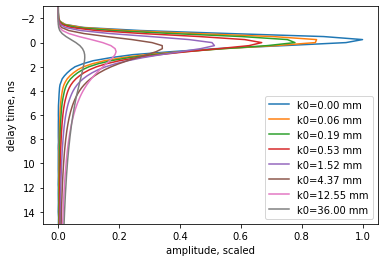

In [2]:
plt.figure(1); plt.clf()
for k0 in list(catalog)[::10]:
    plt.plot(catalog[k0].p, catalog[k0].t, label="k0=%4.2f mm" %(k0*1000.))
plt.gca().set_ylim([15, -3])
plt.legend()
plt.ylabel('delay time, ns')
plt.xlabel('amplitude, scaled')

These correspond to window delays for a $\pm$ 1.5 m window for the median and mean:


(-0.6, 0.1)

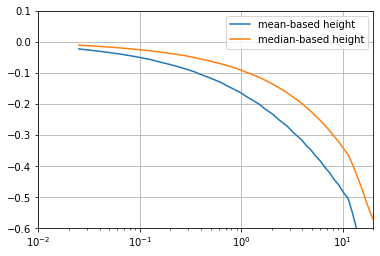

In [3]:
k0s=np.array(list(catalog))
means=np.array([composite_stats(catalog[k0], 20)[0] for k0 in k0s])
meds=np.array([composite_stats(catalog[k0], 20)[1] for k0 in k0s])

plt.figure(2); plt.clf()
plt.semilogx(k0s[1:]*1000, (means[1:]-means[0])*-.15, label='mean-based height')
plt.semilogx(k0s[1:]*1000, (meds[1:]-meds[0])*-.15, label='median-based height')
plt.grid()
plt.legend()
plt.gca().set_xlim([0.01, 20])
plt.gca().set_ylim([-0.6, 0.1])

Spread on the recovered $r_{eff}$ values doesn't seem to bias the recovered delay.  Estimated fitting errors are OTO a factor of 2, or about 6 bins.  A quick simulation yiels about the same delay values for a single waveform as for the composite of 400 waveforms with $r_{eff}$ values distributed by factor of 2 around the $r_{eff}$ for the single waveform:

(-0.5, 0)

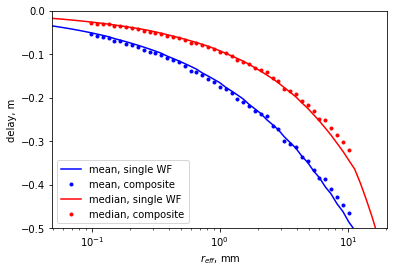

In [4]:
# a fitting error of a factor of 2 is equal to 6 bins, so start the calculation at bin 13 (2 sigma)
ind_vals=np.arange(14, len(k0s)-13)
dist_errors={field:np.zeros_like(ind_vals)+np.NaN for field in ['k0_med','k0_mean', 'k0_med_out','k0_mean_out']}

for count, ind in enumerate(ind_vals):
    k0_dist=k0s[ind] * 10**(np.log10(2)*np.random.randn(400))
    k0_dist = k0_dist[(k0_dist >= k0s[1]) & (k0_dist <= k0s[-1])]
    wf_composite = make_composite_wf(k0_dist, catalog)[0]
    dist_errors['k0_med'][count]=np.median(k0_dist)
    dist_errors['k0_mean'][count]=np.mean(k0_dist)
    dist_errors['k0_mean_out'][count], dist_errors['k0_med_out'][count] = composite_stats(wf_composite, 20)[0:2]
plt.figure()
plt.semilogx(k0s[1:]*1000, (means[1:]-means[0])*-.15,'b', label='mean, single WF')
#plt.semilogx(dist_errors['k0_med']*1000, (dist_errors['k0_mean_out']-means[0])*-.15,'b.', label='mean, composite')
plt.semilogx(k0s[ind_vals]*1000, (dist_errors['k0_mean_out']-means[0])*-.15,'b.', label='mean, composite')

plt.semilogx(k0s[1:]*1000, (meds[1:]-meds[0])*-.15,'r', label='median, single WF')
#plt.semilogx(dist_errors['k0_med']*1000, (dist_errors['k0_med_out']-meds[0])*-.15,'r.', label='median, composite')
plt.semilogx(k0s[ind_vals]*1000, (dist_errors['k0_med_out']-meds[0])*-.15,'r.', label='median, composite')

plt.legend()
plt.ylabel('delay, m')
plt.xlabel('$r_{eff}$, mm')
plt.gca().set_xlim([500*k0s[ind_vals[0]], 2000*k0s[ind_vals[-1]]])
plt.gca().set_ylim([-0.5, 0])

Note that this correspondence only works when plotting the composite-waveform delay against the median of input $r_{eff}$ distribution or the actual center of the input distribution.  Plotting against the mean of the distribution shows that the mean $r_{eff}$ value tends to be significantly larger than the median or the parent-distribution center.

## Composite statistics for the Antarctic surveys

In [5]:
import pointCollection as pc
import glob
import os
import h5py
thedir='/Users/ben/temp/AA_wf_fits/'

field_dict={None:['x','y','t_ctr','t_med','t_sigma','z_sigma']}
D=[]
for file in glob.glob(os.path.join(thedir, '2*/composite_WF/*.h5')):
    D += [pc.data().from_h5(file, field_dict=field_dict)]

with h5py.File(file,'r') as ff:
    t_tx_med=ff.attrs['tx_median']
    t_tx_mean=ff.attrs['tx_mean']
    
D=pc.data().from_list(D)
D.index(np.isfinite(D.x+D.y+D.t_ctr))
MOA_1km=pc.grid.data().from_geotif('/Data/MOA/2009/moa1000_2009_hp1_v1.1.tif', \
            bounds=[(np.min(D.x)-1.e5, np.max(D.x)+1.e5), (np.min(D.y)-1.e5, np.max(D.y)+1.e5)])

In [13]:
%matplotlib widget
plt.figure(figsize=[10, 7]); 
MOA_1km.show(clim=[14000, 17000], cmap='gray')
ii=np.argsort(D.t_med)[::5]
plt.scatter(D.x[ii], D.y[ii], c=(D.t_ctr[ii]-t_tx_mean)*-.15, linewidth=0, cmap='Blues_r', vmin=-0.15, vmax=0); 
hb=plt.colorbar()
hb.set_label('mean-based elevation bias, m')


FigureCanvasNbAgg()

In [14]:
plt.figure(figsize=[10, 7]); 

MOA_1km.show(clim=[14000, 17000], cmap='gray')
ii=np.argsort(D.t_med)[::2]
plt.scatter(D.x[ii], D.y[ii], c=(D.t_med[ii]-t_tx_med)*-.15, linewidth=0, cmap='Blues_r', vmin=-0.15, vmax=0); 
hb=plt.colorbar()
hb.set_label('median-based elevation bias, m')


FigureCanvasNbAgg()

In [18]:
(np.round(plt.gca().get_xlim()), np.round(plt.gca().get_ylim()))

(array([-707937., -350724.]), array([ 75579., 395582.]))

In [22]:
[np.round(np.mean(plt.gca().get_xlim())), np.round(np.mean(plt.gca().get_ylim()))]

[-1597798.0, -23800.0]